# Part1: TTS Inference Demo using NeMo

This notebook aims to synthesise speech samples using the checkpoints including;
*   pretrained models (NGC)
*   trained models (local)



# License

> Copyright 2020 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

This notebook is modified from:
1.   https://github.com/NVIDIA/NeMo/tree/main/tutorials/tts/
2.   https://catalog.ngc.nvidia.com/orgs/nvidia/collections/nemo_tts



# Setting up the Environment


1.   Save a copy in Drive
2.   Use GPU runtime
3.   Install the dependencies



## Save a copy in Drive
In Google Colab, select *File --> Save a copy in Drive*

## Use GPU runtime
select *RunTime -->  Change Runtime Type --> select "GPU" for hardware accelerator* 

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-ed226438-a834-e23b-8287-839b0f1edc67)


## Installation

In [ ]:
# install from source
!git clone https://github.com/NVIDIA/NeMo
!cd NeMo/requirements
!find . -name "requirement*" -type f -exec pip install -r '{}' ';'

In [ ]:
# add NeMo's directory to pythonpath
import sys
sys.path.insert(0, "/content/NeMo")
import nemo

# Checkpoint NeMo model
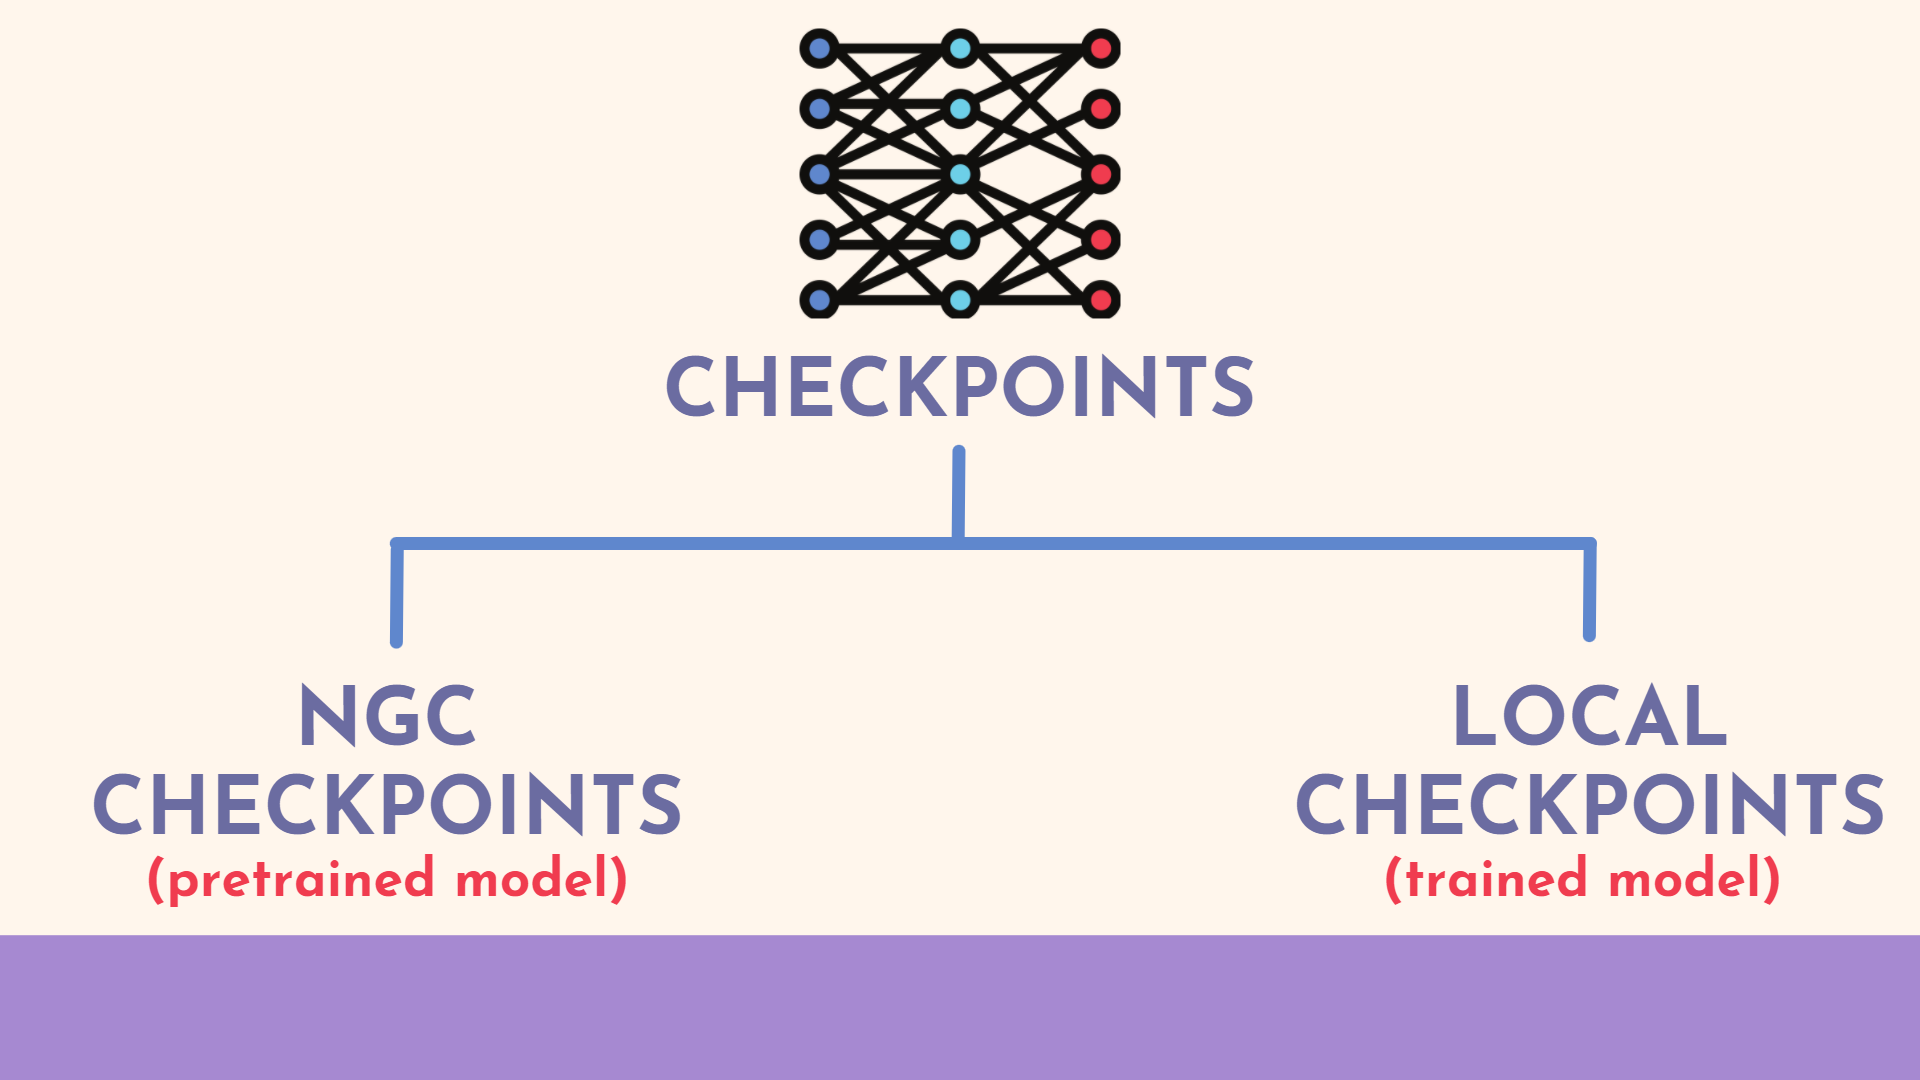

# Load pretrained models (NGC)

This section shows how to load the pretrained model provided by NeMo with two functions;
1.   list_available_models() e.g. *base_class.list_available_models()*
2.   from_pretrained() e.g. *base_class.from_pretrained(model_name)*

# Generate speech from pretrained model

## Download and Load the SpectrogramGenerator model


In [ ]:
from nemo.collections.tts.models.base import SpectrogramGenerator
spec_name = "tts_en_tacotron2"
spec_generator=SpectrogramGenerator.from_pretrained(spec_name).eval().cuda()


## Download and Load the Vocoder model


In [ ]:
from nemo.collections.tts.models.base import Vocoder
vocoder_name="tts_hifigan"
vocoder = Vocoder.from_pretrained(vocoder_name).eval().cuda()

## Input text


## Character to tokenised_id


In [ ]:
#labels: [' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
#        'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']',
#        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
#        'u', 'v', 'w', 'x', 'y', 'z']
token_id = spec_generator.parse("abcdez !\"(),abcdez")
print(token_id)

In [ ]:
text_input = input("Input anything you want to say: ")

In [ ]:
token_id = spec_generator.parse(text_input)
print(token_id)

## Tokenised_id to mel-spectrogram

In [ ]:
spectrogram = spec_generator.generate_spectrogram(tokens=token_id)

In [ ]:
%matplotlib inline

import torch
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

def show_spectrogram(spectrogram):
  with torch.no_grad():
    if spectrogram is not None:
      if isinstance(spectrogram, torch.Tensor):
          spectrogram = spectrogram.to('cpu').numpy()
      if len(spectrogram.shape) == 3:
          spectrogram = spectrogram[0]
      
      imshow(spectrogram, origin="lower")
      plt.show()

show_spectrogram(spectrogram)


## Mel-spectrogram to audio

In [ ]:
audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

In [ ]:
%matplotlib inline
import IPython.display as ipd

def show_audio(audio):
  with torch.no_grad():
    if isinstance(audio, torch.Tensor):
      audio = audio.to('cpu').numpy()
      #print("show audio")
      ipd.display(ipd.Audio(audio, rate=22050))


In [ ]:
show_audio(audio)

In [ ]:
if vocoder_name == "tts_hifigan":
  audio_denoise = vocoder._bias_denoise(audio, spectrogram).squeeze(1)
  show_audio(audio)

## Other pre-trained models
can be found in https://catalog.ngc.nvidia.com/orgs/nvidia/collections/nemo_tts

In [ ]:
spec_generator1=SpectrogramGenerator.from_pretrained("tts_en_glowtts").eval().cuda()
spec_generator2=SpectrogramGenerator.from_pretrained("tts_en_tacotron2").eval().cuda()
spec_generator3=SpectrogramGenerator.from_pretrained("tts_en_fastspeech2").eval().cuda()
spec_generator4=SpectrogramGenerator.from_pretrained("tts_en_fastpitch").eval().cuda()
spec_generator5=SpectrogramGenerator.from_pretrained("tts_en_talknet").eval().cuda()
spec_generator6=SpectrogramGenerator.from_pretrained("tts_en_lj_mixertts").eval().cuda()
spec_generator7=SpectrogramGenerator.from_pretrained("tts_en_lj_mixerttsx").eval().cuda()


In [ ]:
vocoder1 = Vocoder.from_pretrained("tts_hifigan").eval().cuda()
vocoder2 = Vocoder.from_pretrained("tts_melgan").eval().cuda()
vocoder3 = Vocoder.from_pretrained("tts_squeezewave").eval().cuda()
vocoder4 = Vocoder.from_pretrained("tts_uniglow").eval().cuda()
vocoder5 = Vocoder.from_pretrained("tts_waveglow_268m").eval().cuda()
vocoder6 = Vocoder.from_pretrained("tts_waveglow_88m").eval().cuda()
vocoder7 = Vocoder.from_pretrained("tts_en_lj_univnet").eval().cuda()
vocoder8 = Vocoder.from_pretrained("tts_en_libritts_univnet").eval().cuda()


## Text2Wav



In [ ]:
def text2wav(text_input,spec_generator,vocoder,sSpec_name,sVocoder_name):
  token_id = spec_generator.parse(text_input)
  spectrogram = spec_generator.generate_spectrogram(tokens=token_id)
  audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
  print(("%s:%s")%(sSpec_name,sVocoder_name))
  show_audio(audio)

def text2spectrogram(text_input,spec_generator):
  token_id = spec_generator.parse(text_input)
  spectrogram = spec_generator.generate_spectrogram(tokens=token_id)
  return spectrogram

def spectrogram2wav(spectrogram,vocoder,sSpec_name,sVocoder_name):
  audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
  print(("%s:%s")%(sSpec_name,sVocoder_name))
  show_audio(audio)

In [ ]:
text_input="hello, this is a tts inference demo test for today workshop"

text2wav(text_input,spec_generator1,vocoder,"glowtts","hifigan")
text2wav(text_input,spec_generator2,vocoder,"tacotron2","hifigan")

In [ ]:
spectrogram = spec_generator.generate_spectrogram(tokens=token_id)

text_input="hello, this is a tts inference demo test for today workshop"
spectrogram=text2spectrogram(text_input,spec_generator2)

spectrogram2wav(spectrogram,vocoder1,"tacotron2","hifigan")
spectrogram2wav(spectrogram,vocoder2,"tacotron2","melgan")
spectrogram2wav(spectrogram,vocoder6,"tacotron2","tts_waveglow_88m")
spectrogram2wav(spectrogram,vocoder8,"tacotron2","tts_en_libritts_univnet")


# Generate speech from trained models (local)

This section shows how to load the trained model into local directory. (https://catalog.ngc.nvidia.com/orgs/nvidia/collections/nemo_tts)

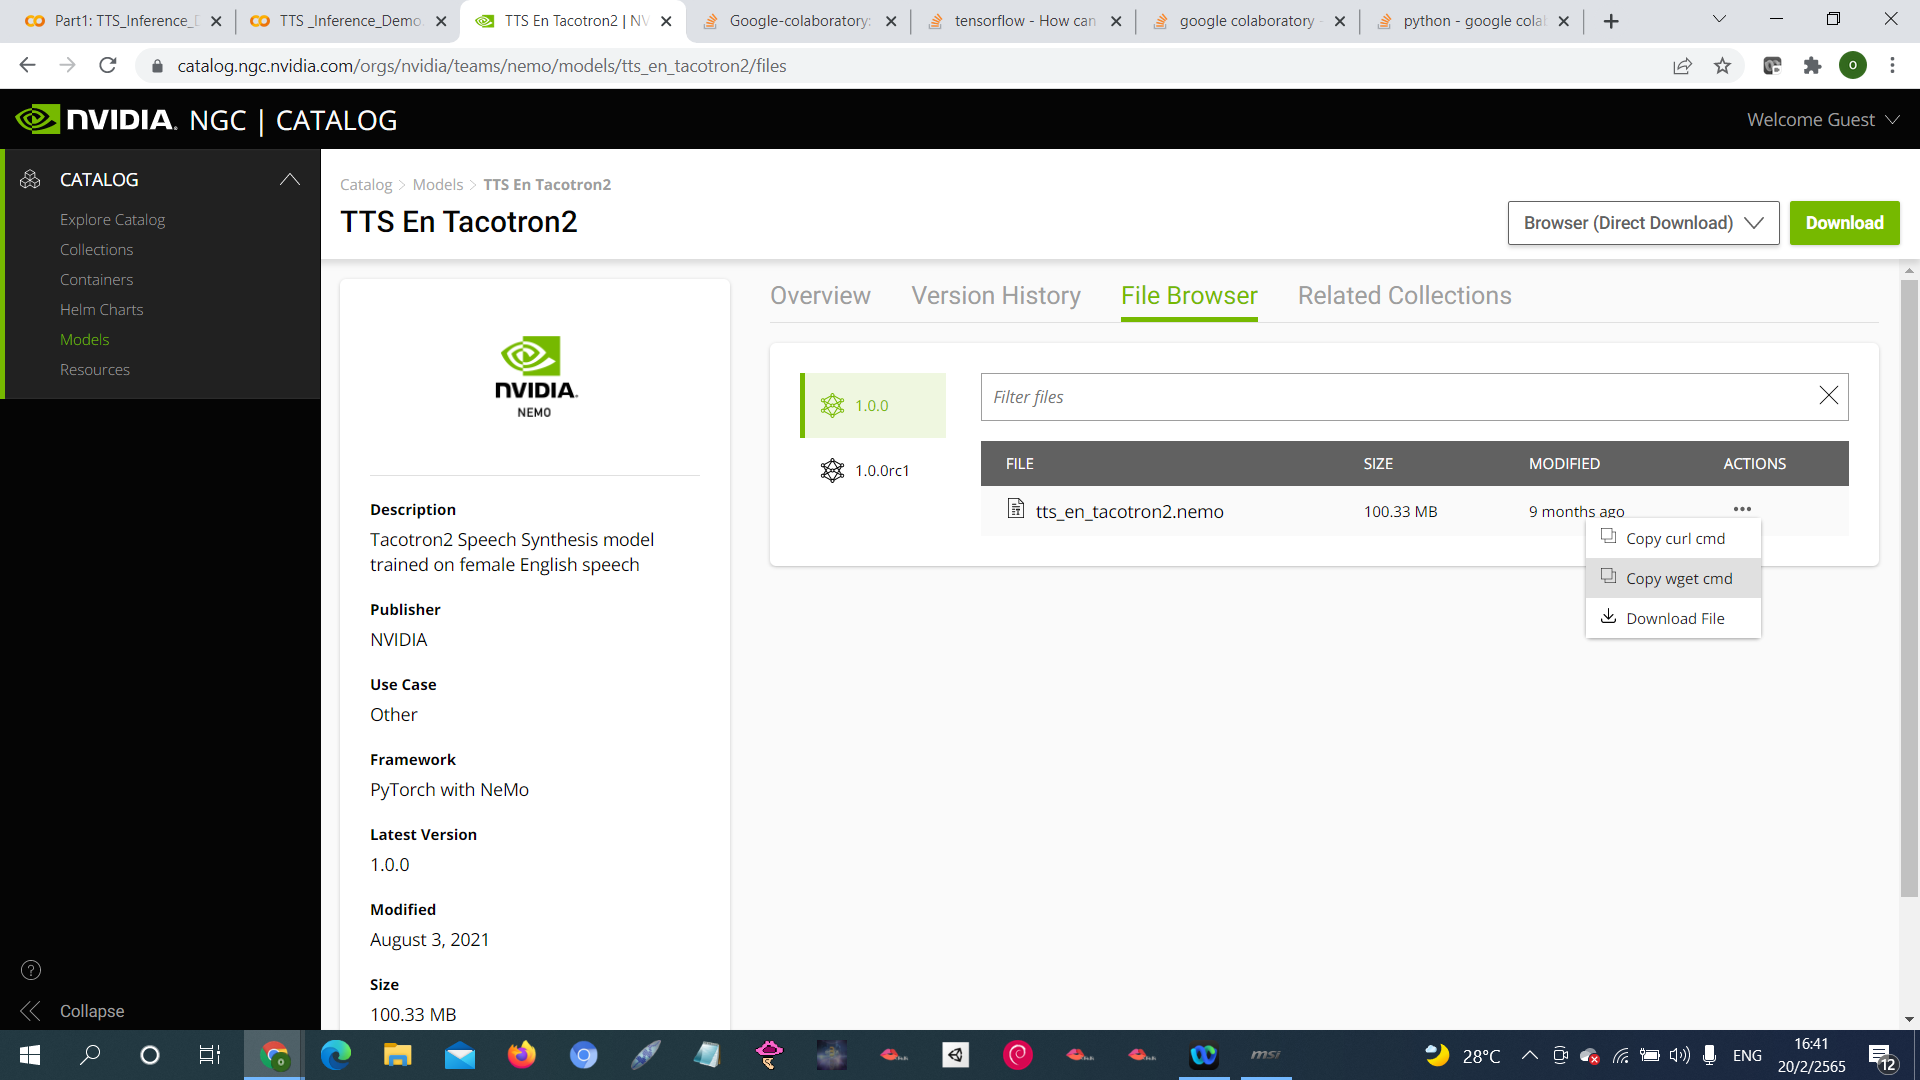

In [ ]:
# download trained model to local
import wget
location_model="https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.0.0/files/tts_en_tacotron2.nemo"
!wget {location_model}

In [ ]:
from nemo.collections.tts.models import Tacotron2Model
tacotron_restoreModel=Tacotron2Model.restore_from(restore_path="tts_en_tacotron2.nemo")

In [ ]:
text2wav(text_input,spec_generator2,vocoder,"tacotron2","hifigan")
text2wav(text_input,tacotron_restoreModel ,vocoder,"tacotron2_restoreModel","hifigan")

# Hands-on

1.   What is your favorite SpectrogramGenerator
2.   What is your favorite Vocoder

